<a href="https://colab.research.google.com/github/giancarlohc/Applied-AI-in-Transportation/blob/main/Project/ProjectCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data Processing


## 1.1 Loading Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install researchpy calmap
import researchpy as rp
import calmap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import ConfusionMatrixDisplay as cmd
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd
import os
import warnings
from sklearn.exceptions import ConvergenceWarning
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

url = "https://raw.githubusercontent.com/giancarlohc/Applied-AI-in-Transportation/main/ProjectAssignmentData/Dataset-PT.csv"
dataset = pd.read_csv(url,skiprows=[0])

## 1.2 Data Exploration

In [4]:
dataset

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(weather)Rain,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,0,0,0,1,0,1,0,0,1
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,0,0,0,1,0,1,0,0,1
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,0,0,0,1,0,1,0,0,1
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,0,0,0,1,0,1,0,0,1
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545098,20220630,4,41362,23,344,13,74,44,341,12,...,0,0,0,0,1,1,0,0,0,1
545099,20220630,4,41362,24,330,15,34,92,344,12,...,0,0,0,0,1,1,0,0,0,1
545100,20220630,4,41362,25,339,17,63,43,330,12,...,0,0,0,0,1,1,0,0,0,1
545101,20220630,4,41362,26,331,0,35,58,339,12,...,0,0,0,0,1,1,0,0,0,1


In [6]:
np.mean(dataset)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


KeyboardInterrupt: ignored

In [ ]:
plt.hist(dataset["arrival_delay"])

In [ ]:
dataset.boxplot(column=["arrival_delay","dwell_time","travel_time_for_previous_section","scheduled_travel_time"])

In [ ]:
dataset.boxplot(column=["upstream_stop_delay","origin_delay","previous_bus_delay","previous_trip_travel_time","traffic_condition","recurrent_delay"])

In [ ]:
np.unique(dataset.isna())

In [ ]:
correlation_matrix = dataset[["arrival_delay","dwell_time","travel_time_for_previous_section","scheduled_travel_time","upstream_stop_delay","origin_delay","previous_bus_delay","previous_trip_travel_time","traffic_condition","recurrent_delay"]].corr()

In [ ]:
plt.figure(figsize=(10, 8))  # Set figure size for better visualization
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
rp.summary_cat(dataset[["weather", "temperature","day_of_week","time_of_day"]])

In [ ]:
plt.hist(dataset["Calendar_date"])

In [ ]:

dates = pd.to_datetime(dataset['Calendar_date'], format='%Y%m%d')

date_frequencies = dates.value_counts().sort_index()

plt.figure(figsize=(12, 6))
date_frequencies.plot(kind='line', linestyle='-', marker='o')
plt.title("Date Frequency")
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(16, 10))
calmap.yearplot(date_frequencies, year=2022)
plt.title("Date Frequency Heatmap for 2022")
plt.show()

In [ ]:
dates

In [ ]:
dataset[0:5]['scheduled_travel_time'].sum()/60

## 1.3 Creation of Training Datasets

### 1.3.1 Creation of Datasets with 1,5,10,15,20 Stop Prediction

In [3]:
count = 0
delayed5 = pd.DataFrame()
delayed10 = pd.DataFrame()
delayed15 = pd.DataFrame()
delayed20 = pd.DataFrame()
for k in set(dataset['Calendar_date']):
  buses = set(dataset[dataset["Calendar_date"]==k]["bus_id"])
  for j in buses:
    pullout = dataset[(dataset['bus_id'] == j) & (dataset['Calendar_date'] == k)]

    pullout5 = pullout.copy()
    pullout5['delayed_delay'] = pullout5['arrival_delay'].shift(-4)
    pullout5 = pullout5.dropna()
    delayed5 = pd.concat((delayed5,pullout5),axis=0)

    pullout10 = pullout.copy()
    pullout10['delayed_delay'] = pullout10['arrival_delay'].shift(-9)
    pullout10 = pullout10.dropna()
    delayed10 = pd.concat((delayed10,pullout10),axis=0)

    pullout15 = pullout.copy()
    pullout15['delayed_delay'] = pullout15['arrival_delay'].shift(-14)
    pullout15 = pullout15.dropna()
    delayed15 = pd.concat((delayed15,pullout15),axis=0)

    pullout20 = pullout.copy()
    pullout20['delayed_delay'] = pullout20['arrival_delay'].shift(-19)
    pullout20 = pullout20.dropna()
    delayed20 = pd.concat((delayed20,pullout20),axis=0)

In [4]:
delayed5

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,delayed_delay
330885,20220416,4,44416,1,-11,0,0,180,4,4,...,0,0,0,1,0,1,0,0,1,54.0
330886,20220416,4,44416,2,33,74,165,75,-11,4,...,0,0,0,1,0,1,0,0,1,64.0
330887,20220416,4,44416,3,32,30,45,69,33,4,...,0,0,0,1,0,1,0,0,1,65.0
330888,20220416,4,44416,4,-6,33,38,156,32,4,...,0,0,0,1,0,1,0,0,1,46.0
330889,20220416,4,44416,5,54,71,85,121,-6,4,...,0,0,0,1,0,1,0,0,1,115.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329904,20220415,4,44057,19,288,40,55,57,260,120,...,0,0,0,1,0,1,0,0,1,179.0
329905,20220415,4,44057,20,237,0,45,93,288,120,...,0,0,0,1,0,1,0,0,1,140.0
329906,20220415,4,44057,21,233,19,42,88,237,120,...,0,0,0,1,0,1,0,0,1,148.0
329907,20220415,4,44057,22,205,0,65,66,233,120,...,0,0,0,1,0,1,0,0,1,151.0


### 1.3.2 Normalizing the Datasets

Z-Score normalization handles outliers better (many in the dataset and important to detect)

In [5]:
columnnames = dataset.columns
numericcolumns = columnnames[4:14].tolist()
numericcolumns.append("delayed_delay")
factorcolumns = columnnames[18:].tolist()
columnstouse = numericcolumns + factorcolumns

In [6]:
scaler = StandardScaler()
delayed5[numericcolumns] = scaler.fit_transform(delayed5[numericcolumns])
delayed10[numericcolumns] = scaler.fit_transform(delayed10[numericcolumns])
delayed15[numericcolumns] = scaler.fit_transform(delayed15[numericcolumns])
delayed20[numericcolumns] = scaler.fit_transform(delayed20[numericcolumns])

In [7]:
delayed5 = delayed5[columnstouse]
delayed10 = delayed10[columnstouse]
delayed15 = delayed15[columnstouse]
delayed20 = delayed20[columnstouse]

### 1.3.3 Splitting the Datasets into Training and Test 80/20%

In [8]:
Y5 = delayed5["delayed_delay"]
X5 = delayed5.drop(columns=["delayed_delay","arrival_delay"])

X5_train, X5_test, Y5_train, Y5_test = train_test_split(X5, Y5, test_size=0.2, random_state=42)

Y10 = delayed5["delayed_delay"]
X10 = delayed5.drop(columns=["delayed_delay","arrival_delay"])

X10_train, X10_test, Y10_train, Y10_test = train_test_split(X10, Y10, test_size=0.2, random_state=42)

Y15 = delayed5["delayed_delay"]
X15 = delayed5.drop(columns=["delayed_delay","arrival_delay"])

X15_train, X15_test, Y15_train, Y15_test = train_test_split(X15, Y15, test_size=0.2, random_state=42)

Y20 = delayed5["delayed_delay"]
X20 = delayed5.drop(columns=["delayed_delay","arrival_delay"])

X20_train, X20_test, Y20_train, Y20_test = train_test_split(X20, Y20, test_size=0.2, random_state=42)

# 2. Model Creation

## 2.1 Model Training

### 2.1.0 Model Training Module 2 - Regression Models

###Linear Regression

###SVR Regression

###XGRegression Regression

In [9]:
#Test Sample
X5_train_SAMPLE =  X5_train.iloc[:500]
X5_test_SAMPLE =   X5_test.iloc[:500]
X10_train_SAMPLE = X10_train.iloc[:500]
X10_test_SAMPLE =  X10_test.iloc[:500]
X15_train_SAMPLE = X15_train.iloc[:500]
X15_test_SAMPLE =  X15_test.iloc[:500]
X20_train_SAMPLE = X20_train.iloc[:500]
X20_test_SAMPLE =  X20_test.iloc[:500]

Y5_train_SAMPLE =  Y5_train.iloc[:500]
Y5_test_SAMPLE =   Y5_test.iloc[:500]
Y10_train_SAMPLE = Y10_train.iloc[:500]
Y10_test_SAMPLE =  Y10_test.iloc[:500]
Y15_train_SAMPLE = Y15_train.iloc[:500]
Y15_test_SAMPLE =  Y15_test.iloc[:500]
Y20_train_SAMPLE = Y20_train.iloc[:500]
Y20_test_SAMPLE =  Y20_test.iloc[:500]

Y5_SAMPLE =  Y5_test.iloc[:500]
X5_SAMPLE =  X5_test.iloc[:500]
Y10_SAMPLE = Y10_test.iloc[:500]
X10_SAMPLE = X10_test.iloc[:500]
Y15_SAMPLE = Y15_test.iloc[:500]
X15_SAMPLE = X15_test.iloc[:500]
Y20_SAMPLE = Y20_test.iloc[:500]
X20_SAMPLE = X20_test.iloc[:500]

# 5 Stops
Best Parameters for Data Size 5: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}

Cross-Validation Score for Data Size 5: 0.6896990017014483

Mean Absolute Error for Data Size 5: 0.33488745459535585

Mean Squared Error for Data Size 5: 0.2305519373008081

R-squared for Data Size 5: 0.7662310430087945
# 10 Stops
Best Parameters for Data Size 10: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}

Cross-Validation Score for Data Size 10: 0.6896990017014483

Mean Absolute Error for Data Size 10: 0.33488745459535585

Mean Squared Error for Data Size 10: 0.2305519373008081

R-squared for Data Size 10: 0.7662310430087945
# 15 Stops
Best Parameters for Data Size 15: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}

Cross-Validation Score for Data Size 15: 0.6896990017014483

Mean Absolute Error for Data Size 15: 0.33488745459535585

Mean Squared Error for Data Size 15: 0.2305519373008081

R-squared for Data Size 15: 0.7662310430087945
# 20 Stops
Best Parameters for Data Size 20: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}

Cross-Validation Score for Data Size 20: 0.6896990017014483

Mean Absolute Error for Data Size 20: 0.33488745459535585

Mean Squared Error for Data Size 20: 0.2305519373008081

R-squared for Data Size 20: 0.7662310430087945

Fitting 5 folds for each of 135 candidates, totalling 675 fits
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.2s
[CV] END gamma=0.01, learni

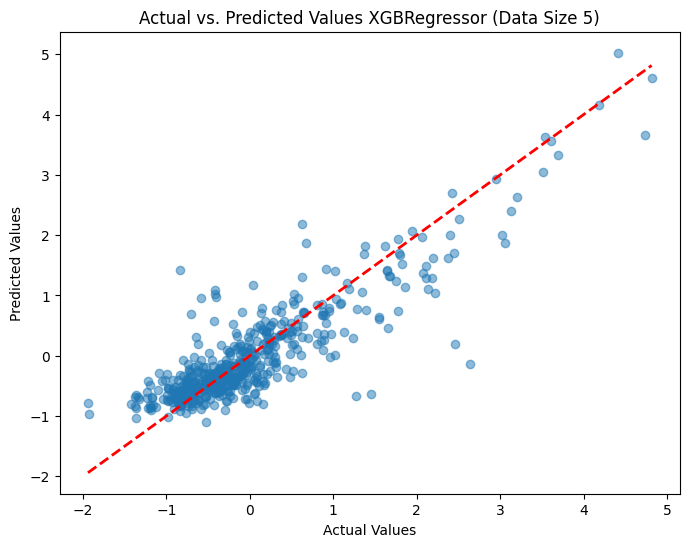

Fitting 5 folds for each of 135 candidates, totalling 675 fits
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.2s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   2.0s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learni

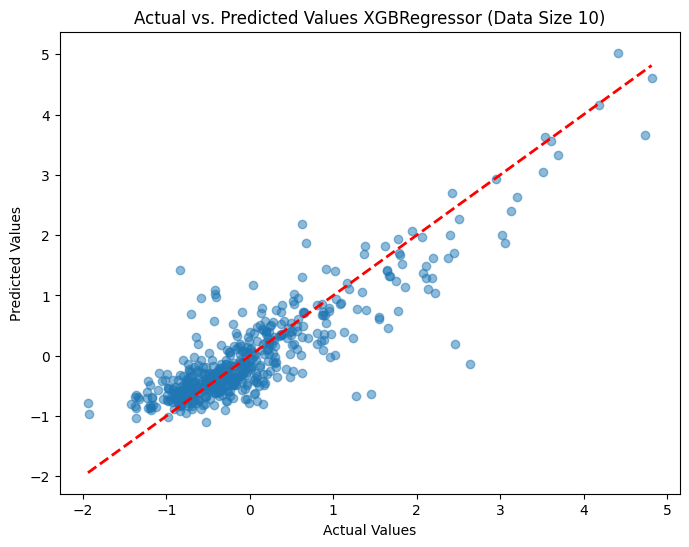

Fitting 5 folds for each of 135 candidates, totalling 675 fits
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learni

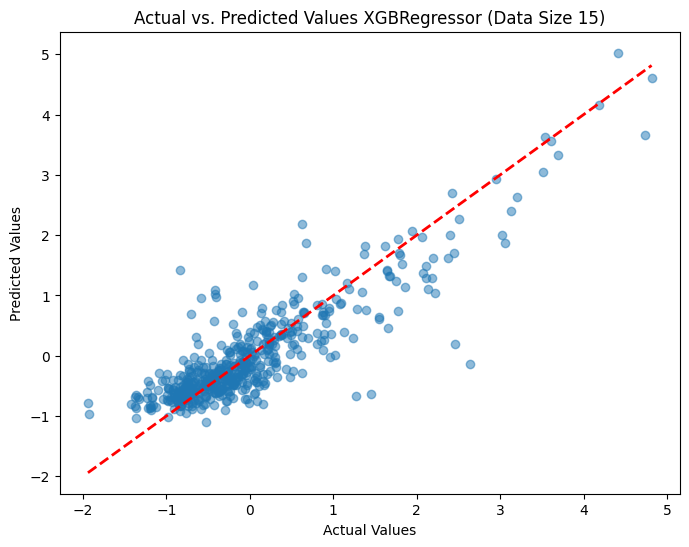

Fitting 5 folds for each of 135 candidates, totalling 675 fits
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learni

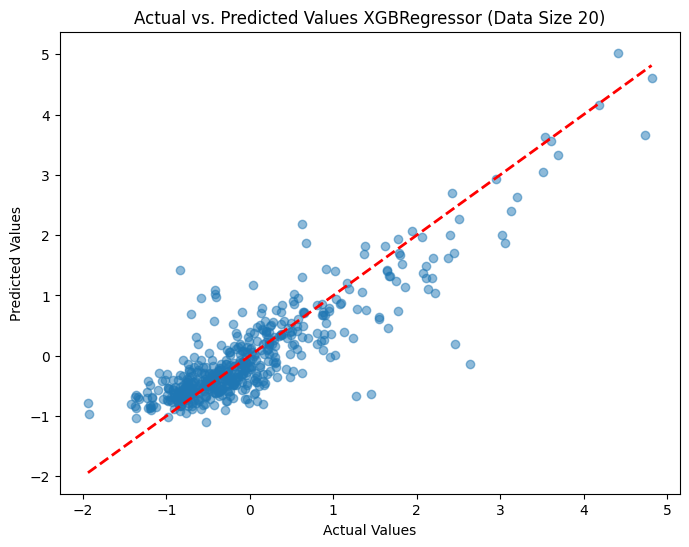

In [11]:

# Define the data sizes
data_sizes = [5, 10, 15, 20]

for size in data_sizes:
    # Create variable names based on the data size
    X_train_SAMPLE = globals()[f"X{size}_train_SAMPLE"]
    X_test_SAMPLE = globals()[f"X{size}_test_SAMPLE"]
    Y_train_SAMPLE = globals()[f"Y{size}_train_SAMPLE"]
    Y_test_SAMPLE = globals()[f"Y{size}_test_SAMPLE"]
    X_SAMPLE = globals()[f"X{size}_SAMPLE"]
    Y_SAMPLE = globals()[f"Y{size}_SAMPLE"]

    # Define hyperparameter search space and model
    params = {
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'gamma': [0.01, 0.1, 1, 10, 100]
    }

    model = XGBRegressor()

    # Perform GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(model, params, cv=5, verbose=2, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_SAMPLE, Y_train_SAMPLE)

    # Get the best parameters
    best_params = grid_search.best_params_
    print(f"Best Parameters for Data Size {size}: {best_params}")
    best_score = grid_search.best_score_
    model = grid_search.best_estimator_

    # Cross-validation of the best model
    cv_scores = cross_val_score(model, X_SAMPLE, Y_SAMPLE, cv=5, verbose=2).mean()
    print(f"Cross-Validation Score for Data Size {size}: {cv_scores}")

    # Train the best model on the training data
    model.fit(X_train_SAMPLE, Y_train_SAMPLE)

    # Make predictions and evaluate the model
    y_pred = model.predict(X_test_SAMPLE)
    mae = mean_absolute_error(Y_test_SAMPLE, y_pred)
    mse = mean_squared_error(Y_test_SAMPLE, y_pred)
    r2 = r2_score(Y_test_SAMPLE, y_pred)
    print(f"Mean Absolute Error for Data Size {size}: {mae}")
    print(f"Mean Squared Error for Data Size {size}: {mse}")
    print(f"R-squared for Data Size {size}: {r2}")

    # Visualization
    plt.figure(figsize=(8, 6))
    plt.scatter(Y_test_SAMPLE, y_pred, alpha=0.5)  # Plot actual vs. predicted values
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Actual vs. Predicted Values XGBRegressor (Data Size {size})")
    plt.plot([min(Y_test_SAMPLE), max(Y_test_SAMPLE)], [min(Y_test_SAMPLE), max(Y_test_SAMPLE)], linestyle='--', color='red', lw=2)
    plt.show()

###KNN Regression

### 2.1.1 Model Training Module 3 - Classification Models

#### 2.1.1.1 One-Hot Encoding, Logistic Regression

In [ ]:
#(1)LR
params = {
     'positive': [False,True],
}
model = LinearRegression()

# Initialize a GridSearchCV object to perform hyperparameter tuning
# - 'estimator': The machine learning model (in this case, 'model') to be tuned.
# - 'param_grid': A dictionary specifying the hyperparameter grid to search.
# - 'cv': The number of cross-validation folds (here, 5-fold cross-validation is used).
# - 'scoring': The evaluation metric used to compare different hyperparameter settings
# --('accuracy','precision','recall, etc. see https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).
grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data to perform hyperparameter tuning
grid_search.fit(X5_train, Y5_train)

# Retrieve the best hyperparameters identified by the grid search
best_params = grid_search.best_params_
print(best_params)
# Retrieve the best cross-validated accuracy score achieved with the best hyperparameters
best_score = grid_search.best_score_

# Set 'model' to be the best estimator (model with the best hyperparameters) identified by the grid search
model = grid_search.best_estimator_

cmd.from_estimator(model, X5_test, Y5_test,cmap='Blues',colorbar=False)


##---------------------Different measurements---------------------------
print(f'Accuracy: {accuracy_score(Y5_test,model.predict(X5_test))}')
print(f'Precision: {precision_score(Y5_test,model.predict(X5_test),average=None)}')
print(f'Recall: {recall_score(Y5_test,model.predict(X5_test),average=None)}')

#### 2.1.1.2 One-Hot Encoding, Logistic RegressionOne-Hot Coding & KNN

In [ ]:
#(2)KNN
params = {
     'n_neighbors': [3, 5, 7, 9],
     'weights': ['uniform', 'distance']
}
model=KNeighborsClassifier()

# Initialize a GridSearchCV object to perform hyperparameter tuning
# - 'estimator': The machine learning model (in this case, 'model') to be tuned.
# - 'param_grid': A dictionary specifying the hyperparameter grid to search.
# - 'cv': The number of cross-validation folds (here, 5-fold cross-validation is used).
# - 'scoring': The evaluation metric used to compare different hyperparameter settings
# --('accuracy','precision','recall, etc. see https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).
grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data to perform hyperparameter tuning
grid_search.fit(x_train, y_train)

# Retrieve the best hyperparameters identified by the grid search
best_params = grid_search.best_params_
print(best_params)
# Retrieve the best cross-validated accuracy score achieved with the best hyperparameters
best_score = grid_search.best_score_

# Set 'model' to be the best estimator (model with the best hyperparameters) identified by the grid search
model = grid_search.best_estimator_

cmd.from_estimator(model, x_test, y_test,cmap='Blues',colorbar=False)


##---------------------Different measurements---------------------------
print(f'Accuracy: {accuracy_score(y_test,model.predict(x_test))}')
print(f'Precision: {precision_score(y_test,model.predict(x_test),average=None)}')
print(f'Recall: {recall_score(y_test,model.predict(x_test),average=None)}')

#### 2.1.1.3 One-Hot Encoding, Logistic RegressionOne-Hot Coding & RF

In [ ]:
#(3)RF
params = {
     'n_estimators': [100, 200, 300],
     'max_depth': [None, 10, 20, 30],
     'min_samples_split': [2, 5, 10],
     'min_samples_leaf': [1, 2, 4]
}
model = RandomForestClassifier(random_state=0)

# Initialize a GridSearchCV object to perform hyperparameter tuning
# - 'estimator': The machine learning model (in this case, 'model') to be tuned.
# - 'param_grid': A dictionary specifying the hyperparameter grid to search.
# - 'cv': The number of cross-validation folds (here, 5-fold cross-validation is used).
# - 'scoring': The evaluation metric used to compare different hyperparameter settings
# --('accuracy','precision','recall, etc. see https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).
grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data to perform hyperparameter tuning
grid_search.fit(x_train, y_train)

# Retrieve the best hyperparameters identified by the grid search
best_params = grid_search.best_params_
print(best_params)
# Retrieve the best cross-validated accuracy score achieved with the best hyperparameters
best_score = grid_search.best_score_

# Set 'model' to be the best estimator (model with the best hyperparameters) identified by the grid search
model = grid_search.best_estimator_

cmd.from_estimator(model, x_test, y_test,cmap='Blues',colorbar=False)


##---------------------Different measurements---------------------------
print(f'Accuracy: {accuracy_score(y_test,model.predict(x_test))}')
print(f'Precision: {precision_score(y_test,model.predict(x_test),average=None)}')
print(f'Recall: {recall_score(y_test,model.predict(x_test),average=None)}')

#### 2.1.1.4 One-Hot Encoding, Logistic RegressionOne-Hot Coding & XGBoost

In [ ]:
#(4)XGBoost
params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5]
}
map = {'air': 0, 'bus': 1, 'car': 2,'rail':3}
y_train = y_train.map(map)
y_test = y_test.map(map)
model =  XGBClassifier()

# Initialize a GridSearchCV object to perform hyperparameter tuning
# - 'estimator': The machine learning model (in this case, 'model') to be tuned.
# - 'param_grid': A dictionary specifying the hyperparameter grid to search.
# - 'cv': The number of cross-validation folds (here, 5-fold cross-validation is used).
# - 'scoring': The evaluation metric used to compare different hyperparameter settings
# --('accuracy','precision','recall, etc. see https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).
grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data to perform hyperparameter tuning
grid_search.fit(x_train, y_train)

# Retrieve the best hyperparameters identified by the grid search
best_params = grid_search.best_params_
print(best_params)
# Retrieve the best cross-validated accuracy score achieved with the best hyperparameters
best_score = grid_search.best_score_

# Set 'model' to be the best estimator (model with the best hyperparameters) identified by the grid search
model = grid_search.best_estimator_

cmd.from_estimator(model, x_test, y_test,cmap='Blues',colorbar=False)


##---------------------Different measurements---------------------------
print(f'Accuracy: {accuracy_score(y_test,model.predict(x_test))}')
print(f'Precision: {precision_score(y_test,model.predict(x_test),average=None)}')
print(f'Recall: {recall_score(y_test,model.predict(x_test),average=None)}')

#### 2.1.1.5 One-Hot Encoding, Logistic RegressionOne-Hot Coding & SVM

In [ ]:
#(5)SVM
## Note: It will costs a long time.
params = {
    'C': [0.1, 1, 10],
}


model= SVC(kernel="linear")

# Initialize a GridSearchCV object to perform hyperparameter tuning
# - 'estimator': The machine learning model (in this case, 'model') to be tuned.
# - 'param_grid': A dictionary specifying the hyperparameter grid to search.
# - 'cv': The number of cross-validation folds (here, 5-fold cross-validation is used).
# - 'scoring': The evaluation metric used to compare different hyperparameter settings
# --('accuracy','precision','recall, etc. see https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).
grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data to perform hyperparameter tuning
grid_search.fit(x_train, y_train)

# Retrieve the best hyperparameters identified by the grid search
best_params = grid_search.best_params_
print(best_params)
# Retrieve the best cross-validated accuracy score achieved with the best hyperparameters
best_score = grid_search.best_score_

# Set 'model' to be the best estimator (model with the best hyperparameters) identified by the grid search
model = grid_search.best_estimator_

cmd.from_estimator(model, x_test, y_test,cmap='Blues',colorbar=False)


##---------------------Different measurements---------------------------
print(f'Accuracy: {accuracy_score(y_test,model.predict(x_test))}')
print(f'Precision: {precision_score(y_test,model.predict(x_test),average=None)}')
print(f'Recall: {recall_score(y_test,model.predict(x_test),average=None)}')

### 2.1.2 Model Training Module 5 - Clustering Models

#### 2.1.2.1 KMeans

In [ ]:
SC_score = []
DB_score = []
CH_score = []

for i in range(2,11):
    print('\033[1m' + "KMeans: n_clusters=" + str(i) + '\033[0m')
    clusters = KMeans(n_clusters=i, random_state=0, n_init=10).fit(vectorized_day_dataset_no_nans)

    if clusters is not None:
            cluster_labels = clusters.labels_

    # Calculate the Silhouette Score
    SC_score.append(silhouette_score(vectorized_day_dataset_no_nans, cluster_labels))
    # Silhouette Score measures the quality of clusters, higher values indicate better separation.

    # Calculate the Davies-Bouldin Score
    DB_score.append(davies_bouldin_score(vectorized_day_dataset_no_nans, cluster_labels))
    # Davies-Bouldin Score measures the average similarity between each cluster and its most similar cluster, lower values indicate better separation.

    # Calculate the Calinski-Harabasz Score
    CH_score.append(calinski_harabasz_score(vectorized_day_dataset_no_nans, cluster_labels))
    # Calinski-Harabasz Score measures the ratio of between-cluster variance to within-cluster variance, higher values indicate better separation.

    # Print the computed cluster quality scores
    print('Silhouette Score:', SC_score[-1])
    print('Davies-Bouldin Score:', DB_score[-1])
    print('Calinski-Harabasz Score:', CH_score[-1])

# List of cluster numbers
cluster_range = list(range(2, 11))

# Silhouette Score Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(cluster_range, SC_score, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

# Davies-Bouldin Score Plot
plt.subplot(1, 3, 2)
plt.plot(cluster_range, DB_score, marker='o', color='red')
plt.title('Davies-Bouldin Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')

# Calinski-Harabasz Score Plot
plt.subplot(1, 3, 3)
plt.plot(cluster_range, CH_score, marker='o', color='green')
plt.title('Calinski-Harabasz Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Score')

plt.tight_layout()
plt.show()

#### 2.1.2.2 Agglomerative Clustering

In [ ]:
SC_score = []
DB_score = []
CH_score = []

for i in range(2,11):
    print('\033[1m' + "Agglomerative Clustering: n_clusters=" + str(i) + '\033[0m')
    clusters = AgglomerativeClustering(n_clusters=i, linkage='ward').fit(vectorized_day_dataset_no_nans)

    if clusters is not None:
            cluster_labels = clusters.labels_

    # Calculate the Silhouette Score
    SC_score.append(silhouette_score(vectorized_day_dataset_no_nans, cluster_labels))
    # Silhouette Score measures the quality of clusters, higher values indicate better separation.

    # Calculate the Davies-Bouldin Score
    DB_score.append(davies_bouldin_score(vectorized_day_dataset_no_nans, cluster_labels))
    # Davies-Bouldin Score measures the average similarity between each cluster and its most similar cluster, lower values indicate better separation.

    # Calculate the Calinski-Harabasz Score
    CH_score.append(calinski_harabasz_score(vectorized_day_dataset_no_nans, cluster_labels))
    # Calinski-Harabasz Score measures the ratio of between-cluster variance to within-cluster variance, higher values indicate better separation.

    # Print the computed cluster quality scores
    print('Silhouette Score:', SC_score[-1])
    print('Davies-Bouldin Score:', DB_score[-1])
    print('Calinski-Harabasz Score:', CH_score[-1])

# List of cluster numbers
cluster_range = list(range(2, 11))

# Silhouette Score Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(cluster_range, SC_score, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

# Davies-Bouldin Score Plot
plt.subplot(1, 3, 2)
plt.plot(cluster_range, DB_score, marker='o', color='red')
plt.title('Davies-Bouldin Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')

# Calinski-Harabasz Score Plot
plt.subplot(1, 3, 3)
plt.plot(cluster_range, CH_score, marker='o', color='green')
plt.title('Calinski-Harabasz Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Score')

plt.tight_layout()
plt.show()

#### 2.1.2.3 DBSCAN

In [ ]:
import matplotlib.pyplot as plt

SC_score = []
DB_score = []
CH_score = []

for i in range(400, 1501, 100):
    print('\033[1m' + "DBSCAN: eps=" + str(i) + '\033[0m')  # changed n_clusters to eps for clarity
    clusters = DBSCAN(eps=i, min_samples=2).fit(vectorized_day_dataset_no_nans)

    if clusters is not None:
        cluster_labels = clusters.labels_

        # Check if valid clusters formed
        if len(set(cluster_labels)) > 1:
            SC_score.append(silhouette_score(vectorized_day_dataset_no_nans, cluster_labels))
            DB_score.append(davies_bouldin_score(vectorized_day_dataset_no_nans, cluster_labels))
            CH_score.append(calinski_harabasz_score(vectorized_day_dataset_no_nans, cluster_labels))
        else:
            SC_score.append(float('nan'))
            DB_score.append(float('nan'))
            CH_score.append(float('nan'))

        # Print the computed cluster quality scores
        print('Silhouette Score:', SC_score[-1])
        print('Davies-Bouldin Score:', DB_score[-1])
        print('Calinski-Harabasz Score:', CH_score[-1])

# List of eps values
eps_range = list(range(400, 1501, 100))

# Silhouette Score Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(eps_range, SC_score, marker='o')
plt.title('Silhouette Score vs. Eps')
plt.xlabel('Eps')
plt.ylabel('Silhouette Score')

# Davies-Bouldin Score Plot
plt.subplot(1, 3, 2)
plt.plot(eps_range, DB_score, marker='o', color='red')
plt.title('Davies-Bouldin Score vs. Eps')
plt.xlabel('Eps')
plt.ylabel('Davies-Bouldin Score')

# Calinski-Harabasz Score Plot
plt.subplot(1, 3, 3)
plt.plot(eps_range, CH_score, marker='o', color='green')
plt.title('Calinski-Harabasz Score vs. Eps')
plt.xlabel('Eps')
plt.ylabel('Calinski-Harabasz Score')

plt.tight_layout()
plt.show()

#### 2.1.2.4 Gaussian Mixture

In [ ]:
SC_score = []
DB_score = []
CH_score = []

for i in range(2,11):
    print('\033[1m' + "Gaussian Mixture: n_clusters=" + str(i) + '\033[0m')
    cluster_labels = GaussianMixture(n_components=i).fit(vectorized_day_dataset_no_nans).predict(vectorized_day_dataset_no_nans)

    # Calculate the Silhouette Score
    SC_score.append(silhouette_score(vectorized_day_dataset_no_nans, cluster_labels))
    # Silhouette Score measures the quality of clusters, higher values indicate better separation.

    # Calculate the Davies-Bouldin Score
    DB_score.append(davies_bouldin_score(vectorized_day_dataset_no_nans, cluster_labels))
    # Davies-Bouldin Score measures the average similarity between each cluster and its most similar cluster, lower values indicate better separation.

    # Calculate the Calinski-Harabasz Score
    CH_score.append(calinski_harabasz_score(vectorized_day_dataset_no_nans, cluster_labels))
    # Calinski-Harabasz Score measures the ratio of between-cluster variance to within-cluster variance, higher values indicate better separation.

    # Print the computed cluster quality scores
    print('Silhouette Score:', SC_score[-1])
    print('Davies-Bouldin Score:', DB_score[-1])
    print('Calinski-Harabasz Score:', CH_score[-1])

# List of cluster numbers
cluster_range = list(range(2, 11))

# Silhouette Score Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(cluster_range, SC_score, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

# Davies-Bouldin Score Plot
plt.subplot(1, 3, 2)
plt.plot(cluster_range, DB_score, marker='o', color='red')
plt.title('Davies-Bouldin Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')

# Calinski-Harabasz Score Plot
plt.subplot(1, 3, 3)
plt.plot(cluster_range, CH_score, marker='o', color='green')
plt.title('Calinski-Harabasz Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Score')

plt.tight_layout()
plt.show()

#### 2.1.2.5 Finding the Optimal Clustering Model for Prediction

In [ ]:
for i in range(1,5):
    if i == 1:
        print('\033[1m' + "KMeans:" + '\033[0m')
        clusters = KMeans(n_clusters=2, random_state=0, n_init=10).fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    elif i == 2:
        print('\033[1m' + "Agglomerative Clustering:" + '\033[0m')
        clusters = AgglomerativeClustering(n_clusters=2, linkage='ward').fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
    elif i == 3:
        print('\033[1m' + "DBSCAN:" + '\033[0m')
        clusters = DBSCAN(eps=1500, min_samples = 5, metric='euclidean').fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

    if 0 < i < 4:
        if clusters is not None:
            cluster_labels = clusters.labels_
    elif i == 4:
        print('\033[1m' + "GaussianMixture:" + '\033[0m')
        cluster_labels = GaussianMixture(n_components=2).fit(vectorized_day_dataset_no_nans).predict(vectorized_day_dataset_no_nans) #check the parameters at  https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_init.html#sphx-glr-auto-examples-mixture-plot-gmm-init-py


    #print(cluster_labels)

    # Calculate the number of clusters by finding unique values in 'cluster_labels'
    n_clusters_t = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

    # Assign colors to days based on clusters
    days_colors, color_to_cluster, style_to_cluster = assign_colors(n_clusters_t, days_not_nans, cluster_labels)
    # The function 'assign_colors' is used to determine colors and styles for visualization.

    # Create a calendar visualization figure
    make_calendar_visualization_figure(days_not_nans, cluster_labels, n_clusters_t, [2021], days_colors,
                                   color_to_cluster, save_figure=None)

    # Initialize a list to store centroid data
    centroids = []

    # Calculate centroids for each cluster
    for i in range(0, n_clusters_t):
        centroid = np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :], 0).reshape(1, nintvals)
        centroids.append(centroid)

    # Define the number of past intervals to consider for classification
    n_past_intervals_for_classification = 5

    # Initialize variables to calculate accuracy metrics
    total_mae = 0
    total_mape = 0
    prediction_counts = 0

    # Loop through each day in the evaluation dataset with no missing values
    for i in range(0, ndays_eval_not_nans):
        # Loop through intervals from n_past_intervals_for_classification to nintvals - 1
        for j in range(n_past_intervals_for_classification, nintvals - 1):
            # Find the closest centroid for the current data point
            centroid_index = find_the_closest_centroid(centroids, vectorized_day_dataset_no_nans_eval[i].reshape(1, nintvals), j - n_past_intervals_for_classification, j)

            # Predict the value for the next interval
            predicted_value = centroids[centroid_index][0, j + 1]

            # Calculate Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE)
            mae_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1])
            mape_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1]) / float(vectorized_day_dataset_no_nans_eval[i][j + 1])

            # Accumulate MAE, MAPE, and count of predictions
            total_mae += mae_t
            total_mape += mape_t
            prediction_counts += 1

    # Calculate and print the prediction accuracy metrics
    print('Prediction accuracy MAE:', total_mae / prediction_counts)
    print('Prediction accuracy MAPE:', total_mape / prediction_counts)

### 2.1.3  Model Training Module 6 - Do we need to make Reduction?

### 2.1.4 Model Training Module 7 - Nural Network Models

In [ ]:
#-------------------------------------------------network construction------------------------------------------------------------------

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=["Layers", "Dropout Rate", "Learning Rate", "MAE"])

# Search parameters
layer_configs = [[32, 64], [64, 128, 64], [128, 256, 128, 64]]
dropout_rates = [0.2, 0.3, 0.4]
learning_rates = [0.001, 0.0001]

for config in layer_configs:
    for dropout_rate in dropout_rates:
        for learning_rate in learning_rates:

            model = Sequential()

            # Add layers from config
            model.add(Dense(config[0], activation='relu', input_dim=22))
            for units in config[1:]:
                model.add(Dense(units, activation='relu'))
                model.add(Dropout(dropout_rate))

            model.add(Dense(1))

            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

            # Callbacks
            early_stop = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
            reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=3)

            # Train without verbose and without ModelCheckpoint for simplicity
            hist = model.fit(X5_train, Y5_train, validation_split=0.2, epochs=200, batch_size=32, callbacks=[early_stop, reduce_lr], verbose=0)

            val_mae = min(hist.history['val_mae'])

            # Append results to the DataFrame
            results_df = results_df.append({
                "Layers": str(config),
                "Dropout Rate": dropout_rate,
                "Learning Rate": learning_rate,
                "MAE": val_mae
            }, ignore_index=True)

# Print the results in a tabular form
print(results_df)

# To find the best configuration, sort the DataFrame based on MAE
best_row = results_df.sort_values(by="MAE").iloc[0]
print("\nBest Configuration:")
print(best_row)

## 2.2 Model Evaluation

What type of model is the best performer?

# 3. Model Optimization

Optimization of the parameters of the best performing model type.